**Purpose :** of this notebook is to aggregate the `Ongouser_activity_stream.csv`, after that add meaningful features from AppleHealthKit data (aggregated data) including a binary column-whether the customer shared their AppleHealthKit data or not. Then add another column-whether the customer subscribed or not from ongouser_modeling_ds-2.csv. Next step is feature reduction in notebook 3 of Part3.

In [1]:
# import libraries here; add more as necessary
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from termcolor import colored
%matplotlib inline

# Remove this later
# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('clean_NewData.csv', parse_dates=[
                 'activity_datetime', 'joined_community_at'])
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,user_id,source,activity_datetime,activity,activity_occurrence,feature_1,feature_2,feature_3,easy_id,joined_community_at
0,0f69074a-3822-4e9a-8424-20c28419528a,segment_tre,2019-08-30 01:32:16.491,became_adopted_user,1.0,30,NaN,NaN,16999.0,2019-08-16 16:18:00
1,ee75a716-67af-47c9-93de-618817bae00d,segment_tre,2019-09-06 16:51:47.062,became_adopted_user,1.0,30,NaN,NaN,14904.0,2019-09-02 17:23:00


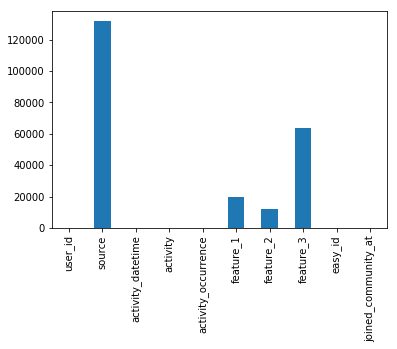

In [3]:
df.isna().sum().plot(kind='bar')

* source, feature 1/2/3 contains missing values- Categorical features where missingness might have an impact on the target.
* Best strategy to impute with `missing`

In [4]:
df.fillna('Missing', inplace=True)
df.isna().sum().sum()

0

In [5]:
df.dtypes

user_id                        object
source                         object
activity_datetime      datetime64[ns]
activity                       object
activity_occurrence            object
feature_1                      object
feature_2                      object
feature_3                      object
easy_id                       float64
joined_community_at    datetime64[ns]
dtype: object

In [6]:
# confirming max duration for user data is for 2 months
(df['activity_datetime'] - df['joined_community_at']).max()

Timedelta('60 days 23:50:05.632000')

### Generating columns to engineer weekly and monthly aggregated features 

In [7]:
# Months
df['1month_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(months=1), axis=1)
df['2month_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(months=2), axis=1)
# Weeks
df['1week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=1), axis=1)
df['2week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=2), axis=1)
df['3week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=3), axis=1)
df['4week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=4), axis=1)
df['5week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=5), axis=1)
df['6week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=6), axis=1)
df['7week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=7), axis=1)
df['8week_4m_joining'] = df.apply(
    lambda x: x['joined_community_at'] + pd.DateOffset(weeks=8), axis=1)
# Generating weekend column
df['weekend'] = df['activity_datetime'].dt.weekday_name
df['weekend'] = df['weekend'].apply(
    lambda x: 1 if x in['Saturday', 'Sunday'] else 0)

### Column: Source 

In [8]:
# Different elements in source column
df['source'].value_counts(normalize=True)

Missing        0.668976
segment_tre    0.192130
segment_ios    0.138894
Name: source, dtype: float64

In [9]:
# Total source over the timeframe
df_source_total = df.groupby('easy_id').agg({'source': ['count']})
df_source_total.columns = ['Total_source']


def aggregate_cols(col, df):
    '''
    Purpose of this function is to aggregate various user activities for different timeframes from the time they 
    join the app to the time they subscribe (with a limit of 2 months)
    '''
    filt_1month = (df['activity_datetime'] <= df['1month_4m_joining'])
    filt_2month = (df['activity_datetime'] > df['1month_4m_joining']) & (
        df['activity_datetime'] <= df['2month_4m_joining'])
    filt_1week = (df['activity_datetime'] <= df['1week_4m_joining'])
    filt_2week = (df['activity_datetime'] > df['1week_4m_joining']) & (
        df['activity_datetime'] <= df['2week_4m_joining'])
    filt_3week = (df['activity_datetime'] > df['2week_4m_joining']) & (
        df['activity_datetime'] <= df['3week_4m_joining'])
    filt_4week = (df['activity_datetime'] > df['3week_4m_joining']) & (
        df['activity_datetime'] <= df['4week_4m_joining'])
    filt_5week = (df['activity_datetime'] > df['4week_4m_joining']) & (
        df['activity_datetime'] <= df['5week_4m_joining'])
    filt_6week = (df['activity_datetime'] > df['5week_4m_joining']) & (
        df['activity_datetime'] <= df['6week_4m_joining'])
    filt_7week = (df['activity_datetime'] > df['6week_4m_joining']) & (
        df['activity_datetime'] <= df['7week_4m_joining'])
    filt_8week = (df['activity_datetime'] > df['7week_4m_joining']) & (
        df['activity_datetime'] <= df['8week_4m_joining'])
    df_weekday = df[df['weekend'] == 0]
    df_weekend = df[df['weekend'] == 1]

    filts = [filt_1month, filt_2month, filt_1week, filt_2week, filt_3week, filt_4week, filt_5week, filt_6week,
             filt_7week, filt_8week, df_weekday, df_weekend]

    df_list = []
    for i in range(len(filts)):
        # Monthly aggregated data
        if i < 2:
            df_x = df[filts[i]]
            df2 = df_x.groupby('easy_id')[col].value_counts().unstack()
            df2.columns = [col1+'_'+str(col)+'_Month'+str(i+1)
                           for col1 in df2.columns]
            df_list.append(df2)
            df2_total = pd.DataFrame(df2.sum(axis=1))
            df2_total.columns = [
                str(col)+'_Month'+str(i+1)+'_Total' for col1 in df2_total.columns]
            df_list.append(df2_total)
        # Weekly aggregated data
        if (i > 1) & (i <= 9):
            df_x = df[filts[i]]
            df2 = df_x.groupby('easy_id')[col].value_counts().unstack()
            df2.columns = [col1+'_'+str(col)+'_Week'+str(i-1)
                           for col1 in df2.columns]
            df_list.append(df2)
            df2_total = pd.DataFrame(df2.sum(axis=1))
            df2_total.columns = [
                str(col)+'_Week'+str(i-1)+'_Total' for col1 in df2_total.columns]
            df_list.append(df2_total)
        # Weekday-weekend aggregated data
        if i == 10:
            df_x = filts[i].groupby('easy_id').agg(
                {'weekend': ['count', 'nunique']})
            df_x.reset_index()
            df_x.columns = [str(col)+'_Weekday_'+str(col1[1]) +
                            '_Total' for col1 in df_x.columns]
            df_list.append(df_x)
        if i == 11:
            df_x = filts[i].groupby('easy_id').agg(
                {'weekend': ['count', 'nunique']})
            df_x.reset_index()
            df_x.columns = [str(col)+'_Weekday_'+str(col1[1]) +
                            '_Total' for col1 in df_x.columns]
            df_list.append(df_x)
    return df_list


# source: over months,weeks, and weekends
df_source = aggregate_cols(col='source', df=df)
data2 = [x for x in df_source]
data_source = pd.concat(data2, axis=1)
# df_source_total
data_source.shape

(553, 44)

### Column: Activity

In [10]:
# Need to aggregate elements, several less frequent activities
df_activity_value_counts = df['activity'].value_counts(normalize=True)
top_activites = df_activity_value_counts[df_activity_value_counts > 0.0047].index.to_list()
df['main_activity'] = df['activity'][df['activity'].isin(top_activites)]
df['main_activity'].fillna('Other', inplace=True)

# Total activity over the timeframe
df_activity_total = df.groupby('easy_id').agg({'main_activity': ['count']})
df_activity_total.columns = ['Main_activity_count_Total']
# Main Activities over months, weeks, weekends
df_main_activity = aggregate_cols(col='main_activity', df=df)
data3 = [x for x in df_main_activity]
data_main_activities = pd.concat(data3, axis=1)
data_main_activities.shape

(553, 194)

### Column: Feature_1

In [11]:
# Grouping less frequent elements taht could be put together
# Anything with an 'error'
filt = df['feature_1'].str.contains(r'error')
df.loc[filt, 'feature_1'] = 'error'
# Anything with a fitness
filt2 = df['feature_1'].str.contains(
    r'fitness|training|Run|run|Fitness|Training|Workout|workout')
df.loc[filt2, 'feature_1'] = 'fitness-training'

# Need to aggregate elements, several less frequent activities
df_feature1_value_counts = df['feature_1'].value_counts(normalize=True)
top_feature1 = df_feature1_value_counts[df_feature1_value_counts > 0.01].index.to_list()
df['feature_1_1'] = df['feature_1'][df['feature_1'].isin(top_feature1)]
df['feature_1_1'].fillna('Other', inplace=True)

# Total feature1_1 over the timeframe
df_feature1_1_total = df.groupby('easy_id').agg(
    {'feature_1_1': ['count', 'nunique']})
df_feature1_1_total.columns = [
    'Feature1_1_count_Total', 'Feature1_1_count_nUnique']
# Different Feature1 over months, weeks, weekends
df_feature_1_1 = aggregate_cols(col='feature_1_1', df=df)
data4 = [x for x in df_feature_1_1]
data_feature_1_1 = pd.concat(data4, axis=1)
data_feature_1_1.shape

(553, 144)

### Column: Feature_2
Data narrators NOT sure what this is, having several infrequent element and also missing values. I would like to check if model suggests missingness has any impact on subscription

In [12]:
df['feature_2_1'] = df['feature_2'].map(lambda x: 1 if x is 'Missing' else 0)
df['feature_2_1'] = df['feature_2_1'].map({1: 'Missing', 0: 'Not-Misisng'})

In [13]:
# Count-Unique Feature 2 per user
df_feature2_total = df.groupby('easy_id').agg(
    {'feature_2': ['count', 'nunique']})
df_feature2_total.columns = ['Feature_2_count_Total', 'Feature_2_nunique']

# Missing vs Not-missing
df_feature_2_1 = df.groupby('easy_id').feature_2_1.value_counts().unstack()
df_feature_2_1.columns = [
    'df_feature_2_1_missing', 'df_feature_2_1_notMissing']

# Different Feature2 over months, weeks, weekends
df_feature_2_MW = aggregate_cols(col='feature_2_1', df=df)
data5 = [x for x in df_feature_2_MW]
data_feature2_1_MW = pd.concat(data5, axis=1)
data_feature2_1_MW.shape

(553, 34)

### Column: Feature_3

In [14]:
df['feature_3_1'] = df['feature_3'].map(lambda x: 1 if x is 'Missing' else 0)
df['feature_3_1'] = df['feature_3_1'].map({1: 'Missing', 0: 'Not-Misisng'})

In [15]:
# Count-Unique Feature 3 per user
df_feature3_total = df.groupby('easy_id').agg(
    {'feature_3': ['count', 'nunique']})
df_feature3_total.columns = ['Feature_3_count_Total', 'Feature_3_nunique']

# Missing vs Not-missing
df_feature_3_1 = df.groupby('easy_id').feature_3_1.value_counts().unstack()
df_feature_3_1.columns = [
    'df_feature_3_1_missing', 'df_feature_3_1_notMissing']

# Different Feature3 over months, weeks, weekends
df_feature_3_MW = aggregate_cols(col='feature_3_1', df=df)
data6 = [x for x in df_feature_3_MW]
data_feature3_MW = pd.concat(data6, axis=1)
data_feature3_MW.shape

(553, 34)

### Columns: activity_occurance

In [16]:
filt = df['activity_occurrence'] == 'Missing'
df.loc[filt, 'activity_occurrence'] = 0

In [17]:
def activity_occurence(df, col):
    aggregations = ['count', 'sum', 'std']
    # df['activity_occurrence'].astype('int')
    df_list = []
    for i in range(len(aggregations)):
        df_new = pd.pivot_table(index='easy_id', columns=col,
                                values='activity_occurrence', aggfunc=aggregations[i], data=df)
        df_new.columns = [str(
            col)+'_main_activity_vs_activity_occurence_'+str(aggregations[i]) for col in df_new]
        df_list.append(df_new)
    return df_list


ac_occurence = activity_occurence(df=df, col='main_activity')
data7 = [x for x in ac_occurence]
ac_occurence = pd.concat(data7, axis=1)
ac_occurence.shape

(553, 54)

In [18]:
def activity_occurence_MW(col, df):
    '''
    Purpose of this function is to make pivot_tables for finding activity occurences of specific 
    main activities for different timeframes from the time they join the app to the time they 
    subscribe (with a limit of 2 months)

    '''
    filt_1month = (df['activity_datetime'] <= df['1month_4m_joining'])
    filt_2month = (df['activity_datetime'] > df['1month_4m_joining']) & (
        df['activity_datetime'] <= df['2month_4m_joining'])
    filt_1week = (df['activity_datetime'] <= df['1week_4m_joining'])
    filt_2week = (df['activity_datetime'] > df['1week_4m_joining']) & (
        df['activity_datetime'] <= df['2week_4m_joining'])
    filt_3week = (df['activity_datetime'] > df['2week_4m_joining']) & (
        df['activity_datetime'] <= df['3week_4m_joining'])
    filt_4week = (df['activity_datetime'] > df['3week_4m_joining']) & (
        df['activity_datetime'] <= df['4week_4m_joining'])
    filt_5week = (df['activity_datetime'] > df['4week_4m_joining']) & (
        df['activity_datetime'] <= df['5week_4m_joining'])
    filt_6week = (df['activity_datetime'] > df['5week_4m_joining']) & (
        df['activity_datetime'] <= df['6week_4m_joining'])
    filt_7week = (df['activity_datetime'] > df['6week_4m_joining']) & (
        df['activity_datetime'] <= df['7week_4m_joining'])
    filt_8week = (df['activity_datetime'] > df['7week_4m_joining']) & (
        df['activity_datetime'] <= df['8week_4m_joining'])

    filts = [filt_1month, filt_2month, filt_1week, filt_2week, filt_3week, filt_4week, filt_5week, filt_6week,
             filt_7week, filt_8week]
    aggregations = ['count', 'sum', 'std']

    df_list = []
    for i in range(len(filts)):
        # Monthly aggregated data
        if i < 2:
            df_x = df[filts[i]]
            for n in range(len(aggregations)):
                df_new = pd.pivot_table(index='easy_id', columns=col,
                                        values='activity_occurrence', aggfunc=aggregations[n], data=df_x)
                df_new.columns = [str(col)+'_main_activity_vs_activity_occurence_'+str(
                    aggregations[n])+'_Month'+str(i+1) for col in df_new]
                df_list.append(df_new)

                df_new_total = pd.DataFrame(df_new.sum(axis=1))
                df_new_total.columns = [str(col)+'_main_activity_vs_activity_occurence_'+str(
                    aggregations[n])+'_Month'+'_Total'+str(i+1) for col1 in df_new_total.columns]
                df_list.append(df_new_total)

        # Weekly aggregated data
        if (i > 1) & (i <= 9):
            df_x = df[filts[i]]
            for n in range(len(aggregations)):
                df_new = pd.pivot_table(index='easy_id', columns=col,
                                        values='activity_occurrence', aggfunc=aggregations[n], data=df_x)
                df_new.columns = [str(col)+'_main_activity_vs_activity_occurence_'+str(
                    aggregations[n])+'_Week'+str(i-1) for col in df_new]
                df_list.append(df_new)

                df_new_total = pd.DataFrame(df_new.sum(axis=1))
                df_new_total.columns = [str(col)+'_main_activity_vs_activity_occurence_'+str(
                    aggregations[n])+'_Week'+'_Total'+str(i-1) for col1 in df_new_total.columns]
                df_list.append(df_new_total)
                df_list.append(df_new_total)
    return df_list


df_activity_occurence_MW = activity_occurence_MW(col='main_activity', df=df)
data8 = [x for x in df_activity_occurence_MW]
df_activity_occurence_MW = pd.concat(data8, axis=1)
print(df_activity_occurence_MW.shape)

# Weekday-weekend aggregated data
df_weekday = df.pivot_table(
    index='easy_id', columns='weekend', values='activity_occurrence', aggfunc='sum')
df_weekday.columns = ['Avg_Weekday_Count_Total', 'Avg_Weekend_Count_Total']
# Averaging activity occurence over weekday and weekend
df_weekday['Avg_Weekday_Count_Total'] = df_weekday['Avg_Weekday_Count_Total']/5
df_weekday['Avg_Weekend_Count_Total'] = df_weekday['Avg_Weekend_Count_Total']/2

(553, 594)


In [19]:
df_total = pd.concat([data_source, df_source_total, df_activity_total, data_main_activities,
                      df_feature1_1_total, data_feature_1_1, df_feature2_total, df_feature_2_1,
                      data_feature2_1_MW, df_feature3_total, df_feature_3_1, data_feature3_MW, ac_occurence,
                      df_activity_occurence_MW, df_weekday], axis=1)
df_total.shape

(553, 1112)

## Incorporating data from synced AppleHealthKit Data
Rules: shared data: 1, not shared:0 #cluster: 0, cluster:1, rest:Missing - categorical<br>
Top features that helped to separate individuals into different clusters

In [20]:
df = pd.read_csv('clean_NewData.csv', parse_dates=[
                 'activity_datetime', 'joined_community_at'])
df.drop(columns=['Unnamed: 0'], inplace=True)

dicti = {}
for i in df['user_id'].unique():
    filt = df['user_id'] == i
    dicti[i] = df.loc[filt, 'easy_id'].unique()[0]

dicti2 = {}
for i in df['easy_id'].unique():
    filt = df['easy_id'] == i
    dicti2[i] = df.loc[filt, 'user_id'].unique()[0]

In [21]:
# AppleHealthData
df_x = pd.read_csv("df_clean.csv", parse_dates=["startdate", "enddate"])
df_x.head(2)

,_id,owner,easy_id,source,type,startdate,enddate,value,continent,city
0,013dbe8e-4388-571a-a475-46cdccb95124,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-heart-rate,2019-05-03 14:53:31.783,2019-05-03 14:53:31.783,100.000000,America,New_York
1,01cfa004-e070-59a9-9044-a33df3d0e5ed,f9946d46-0b26-444c-bf9f-d6322c0c0ce7,0,apple,health-step-distance,2019-06-28 16:59:51.148,2019-06-28 16:59:53.706,2.549228,America,New_York


In [22]:
df_x['easy_id2'] = df_x['owner'].map(dicti)
df_z = df_x.loc[:, ['owner', 'easy_id2']]
df_z2 = df_z[df_z['easy_id2'].notna()]

# People who synced AppleHealthKitData
synced_data = df_z2['easy_id2'].to_list()
# Integrating that into the engineered aggregated data
df_total['shared_apple_data'] = df_total.index.isin(synced_data)
df_total['shared_apple_data'] = df_total['shared_apple_data'].map({
                                                                  True: 1, False: 0})

In [23]:
# Adding more data from aggregated ApplehealthKit # clusters # columns that segregate the clusters well
df_apple_agg = pd.read_csv('df_2_add_2_DataWorkoutRun.csv')
df_apple_agg['easy_id2'] = df_apple_agg['owner'].map(dicti)
df_apple_agg_selected = df_apple_agg[df_apple_agg['easy_id2'].notna()]
df_apple_agg_selected.index = df_apple_agg_selected['easy_id2']
df_apple_agg_selected = df_apple_agg_selected.drop(
    columns=['easy_id', 'owner', 'easy_id2'])

# Total data from all aggregated columns from DataWorkOutRun and AppleHealthKitData (for sync in users)
df_total = pd.concat([df_total, df_apple_agg_selected], axis=1)
# Removing missing values
df_total['kmeans_pred'] = df_total['kmeans_pred'].fillna('Missing')

In [24]:
df_total['owner'] = df_total.index.map(dicti2)
df_total.to_csv("new_ongo_aggregated.csv", index=True)
df = pd.read_csv("new_ongo_aggregated.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,Missing_source_Month1,segment_ios_source_Month1,segment_tre_source_Month1,source_Month1_Total,Missing_source_Month2,segment_ios_source_Month2,segment_tre_source_Month2,source_Month2_Total,Missing_source_Week1,segment_ios_source_Week1,...,Total_activity_weekday,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner
0,408.0,135.0,NaN,543.0,NaN,NaN,NaN,NaN,408.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,0dfd864a-516c-4bdf-988d-d7536083aa6a
1,42.0,69.0,NaN,111.0,NaN,NaN,NaN,NaN,42.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,53240e6d-8771-4bd3-9921-34697581d01e


In [25]:
df_subscription = pd.read_csv(
    'ongouser_modeling_ds-2.csv', parse_dates=['joined_community_at'])
df_subscription.drop(columns=['Unnamed: 0'], inplace=True)
df_subscription.head(2)

,joined_community_at,community_type,goal,community,metric_started_app_session_week1,metric_started_app_session_week2,metric_started_app_session_week3,metric_started_app_session_week4,metric_complete_session_gettingstarted_week4,metric_complete_session_welcome_week4,...,metric_session_start_day_0,metric_session_start_day_1_30,metric_session_start_day_30_60,metric_session_start_day_60_up,_id,flag_startsession_b4_subs,flag_starttrial_b4_subs,flag_companysession_b4_subs,flag_compquickstart_b4_subs,flag_enrolprgm_b4_subs
0,2020-01-17 15:50:00,running,running.health,The Run Experience,1.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,bc03395a-222e-42d3-be3f-d88878b57640,NaN,NaN,NaN,NaN,NaN
1,2020-01-17 15:43:00,running,running.race,The Run Experience,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,c4b763d9-2733-4d89-b889-3b2d92e8e2a1,NaN,NaN,NaN,NaN,NaN


In [26]:
from tqdm import tqdm_notebook
subscription = []
for index1, row1 in tqdm_notebook(df.iterrows()):
    # print(row1['owner'])
    for index2, row2 in df_subscription.iterrows():
        if row1['owner'] == row2['_id']:
            subscription.append(row2['converted_to_started_subscription'])

df['subscription'] = subscription
# Balanced target in the new dataset
df['subscription'].value_counts()

0    279
1    274
Name: subscription, dtype: int64

In [27]:
df.to_csv("new_ongo_aggregated.csv", index=True)
df = pd.read_csv("new_ongo_aggregated.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

,Missing_source_Month1,segment_ios_source_Month1,segment_tre_source_Month1,source_Month1_Total,Missing_source_Month2,segment_ios_source_Month2,segment_tre_source_Month2,source_Month2_Total,Missing_source_Week1,segment_ios_source_Week1,...,health-step-distance_Total.2,Other_health-step-count,apple_health-flights-climbed,health-flights-climbed_Total.2,health-step-distance_Total.3,1_health-step-count,health-step-count_Total.3,kmeans_pred,owner,subscription
0,408.0,135.0,NaN,543.0,NaN,NaN,NaN,NaN,408.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,0dfd864a-516c-4bdf-988d-d7536083aa6a,0
1,42.0,69.0,NaN,111.0,NaN,NaN,NaN,NaN,42.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,53240e6d-8771-4bd3-9921-34697581d01e,0


In [28]:
###### Next: Part C. 3. FeatureSpaceReduction_Ongo_UserActivity_AppleHealthkit_G.ipynb ######